In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import librosa
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind, mannwhitneyu, skew, kurtosis, f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from joblib import Parallel, delayed

In [3]:
from utils import load_config, perform_statistical_tests
from data.load.data_loader import get_codecfake_audio_id_list, load_audio_data
from features import (
    LowLevelFeatureExtractor, 
    HighLevelFeatureExtractor, 
    plot_low_level_feature_dist, 
    plot_high_level_feature_dist, 
    perform_pca_and_plot
)

In [4]:
config    = load_config()
cache_dir = config['data_paths']['codecfake']['cache_files']
audio_ids = get_codecfake_audio_id_list()

In [5]:
iterable_ds = load_audio_data(
    audio_ids=audio_ids[:500],
    dataset='codecfake',
    cache_dir=cache_dir
)

In [6]:
rows = []
for audio in iterable_ds:
    audio_id  = audio['audio_id']
    audio_arr = audio['audio']['array']
    srate     = audio['audio']['sampling_rate']
    real_fake = audio['real_or_fake']

    rows.append({
        'audio_id': audio_id,
        'audio_arr': audio_arr,
        'srate': srate,
        'real_or_fake': real_fake
    })

In [7]:
df = pd.DataFrame(rows)
df.head()

,audio_id,audio_arr,srate,real_or_fake
0,p225_002,"[-0.0045166015625, -0.00665283203125, -0.00607...",48000,R
1,p225_002,"[0.001953125, 0.001556396484375, 0.00164794921...",16000,F03
2,p225_002,"[-0.001220703125, -0.001129150390625, -0.00103...",24000,F04
3,p225_002,"[0.001861572265625, 0.001922607421875, 0.00195...",16000,F01
4,p225_002,"[-0.00335693359375, -0.0032958984375, -0.00320...",48000,F05


### Detailed Low Level Features

In [8]:
audio_processor = LowLevelFeatureExtractor(target_sr=16000, include_only=['voice_quality'])

In [9]:
low_level_features   = pd.DataFrame(list(audio_processor.low_level_feature_generator(df.iloc[:20])))
low_level_feature_df = pd.DataFrame(low_level_features)
low_level_feature_df.head()

Processing Audios: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


,audio_id,real_or_fake,jitter_local,jitter_rap,jitter_ppq5,shimmer_local,shimmer_apq3,shimmer_apq5,shimmer_dda,hnr
0,p225_002,R,0.019678,0.008011,0.009951,0.071643,0.020144,0.026690,0.060432,13.445119
1,p225_002,F03,0.023747,0.009809,0.010080,0.069989,0.020712,0.031683,0.062136,16.470543
2,p225_002,F04,0.021938,0.009088,0.011882,0.101849,0.041155,0.055187,0.123465,12.076429
3,p225_002,F01,0.023562,0.010110,0.010417,0.068337,0.023278,0.035379,0.069833,15.256534
4,p225_002,F05,0.025659,0.010528,0.014228,0.090644,0.032467,0.041497,0.097402,12.662761


In [10]:
low_level_feature_df = pd.DataFrame(low_level_features)
for feature in [col for col in low_level_feature_df.columns if col not in ['audio_id', 'real_or_fake']]:
    if isinstance(low_level_feature_df[feature].iloc[0], np.ndarray):
        plot_low_level_feature_dist(low_level_feature_df, feature)

**No Obvious/Significant Difference in the distribution of detailed low level features**

In [11]:
del low_level_features
del low_level_feature_df

### Extract High level features

In [12]:
audio_processor = LowLevelFeatureExtractor(target_sr=16000, include_only=['voice_quality'])
feature_computer = HighLevelFeatureExtractor()

In [13]:
low_level_gen        = audio_processor.low_level_feature_generator(df.iloc[:20])
high_level_features  = list(feature_computer.high_level_feature_generator(low_level_gen))
high_level_features_df = pd.DataFrame(high_level_features)
high_level_features_df

Processing Audios: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]


,audio_id,real_or_fake,jitter_local,jitter_rap,jitter_ppq5,shimmer_local,shimmer_apq3,shimmer_apq5,shimmer_dda,hnr
0,p225_002,R,0.019678,0.008011,0.009951,0.071643,0.020144,0.026690,0.060432,13.445119
1,p225_002,F03,0.023747,0.009809,0.010080,0.069989,0.020712,0.031683,0.062136,16.470543
2,p225_002,F04,0.021938,0.009088,0.011882,0.101849,0.041155,0.055187,0.123465,12.076429
3,p225_002,F01,0.023562,0.010110,0.010417,0.068337,0.023278,0.035379,0.069833,15.256534
4,p225_002,F05,0.025659,0.010528,0.014228,0.090644,0.032467,0.041497,0.097402,12.662761
5,p225_002,F02,0.019519,0.007140,0.008774,0.081084,0.030641,0.038122,0.091923,15.653361
6,p225_002,F06,0.023747,0.009809,0.010080,0.069989,0.020712,0.031683,0.062136,16.470543
7,p225_003,R,0.027136,0.011247,0.012434,0.109424,0.031839,0.053373,0.095516,11.531919
8,p225_003,F04,0.029113,0.013515,0.013418,0.116588,0.048034,0.062580,0.144102,10.556453
9,p225_003,F03,0.025888,0.010785,0.012556,0.095792,0.025235,0.050044,0.075705,14.383896


**Using Parallel Processing**

In [14]:
def extract_features(row, audio_processor, feature_computer):
    low_level_features = audio_processor.extract_features(row)
    high_level_features = feature_computer.compute_high_level_features(low_level_features)
    return high_level_features


In [15]:
audio_processor  = LowLevelFeatureExtractor(target_sr=16000, include_only=['voice_quality'])
feature_computer = HighLevelFeatureExtractor()

high_level_features   = Parallel(n_jobs=4)(delayed(extract_features)(row, audio_processor, feature_computer) for _, row in df.iterrows())
high_level_feature_df = pd.DataFrame(high_level_features)
high_level_feature_df

,audio_id,real_or_fake,jitter_local,jitter_rap,jitter_ppq5,shimmer_local,shimmer_apq3,shimmer_apq5,shimmer_dda,hnr
0,p225_002,R,0.019678,0.008011,0.009951,0.071643,0.020144,0.026690,0.060432,13.445119
1,p225_002,F03,0.023747,0.009809,0.010080,0.069989,0.020712,0.031683,0.062136,16.470543
2,p225_002,F04,0.021938,0.009088,0.011882,0.101849,0.041155,0.055187,0.123465,12.076429
3,p225_002,F01,0.023562,0.010110,0.010417,0.068337,0.023278,0.035379,0.069833,15.256534
4,p225_002,F05,0.025659,0.010528,0.014228,0.090644,0.032467,0.041497,0.097402,12.662761
...,...,...,...,...,...,...,...,...,...,...
3495,p227_037,R,0.028083,0.008991,0.011082,0.122711,0.042446,0.051660,0.127339,8.732807
3496,p227_037,F05,0.035406,0.015551,0.014947,0.105195,0.031963,0.043457,0.095890,8.183979
3497,p227_037,F01,0.022854,0.009321,0.008212,0.128506,0.047849,0.050148,0.143546,8.130547
3498,p227_037,F06,0.029393,0.012130,0.008864,0.126056,0.051968,0.071199,0.155904,8.747958


In [16]:
high_level_feature_df.columns[high_level_feature_df.isna().sum() > 0]

Index([], dtype='object')

In [17]:
stats_df = perform_statistical_tests(high_level_feature_df)
stats_df

,feature,t_stat,t_p_val,u_stat,u_p_val,effect_size,f_stat,f_p_val
0,jitter_local,-2.036579,4.206985e-02,710801.0,6.096087e-02,-0.096526,3.849557,4.983830e-02
1,jitter_rap,-3.679963,2.514898e-04,668416.0,9.624023e-05,-0.175668,12.922886,3.290687e-04
2,jitter_ppq5,-4.625144,4.402581e-06,671675.0,1.810469e-04,-0.209092,16.667181,4.554132e-05
3,shimmer_local,-3.576043,3.729168e-04,678343.0,6.140152e-04,-0.169354,11.832329,5.889212e-04
4,shimmer_apq3,-9.869035,8.862976e-22,578186.0,2.155795e-16,-0.428947,66.237775,5.498481e-16
5,shimmer_apq5,-6.788167,2.279717e-11,620505.0,6.011186e-10,-0.305130,35.182505,3.294087e-09
6,shimmer_dda,-9.869035,8.862976e-22,578186.0,2.155795e-16,-0.428947,66.237775,5.498481e-16
7,hnr,5.581136,3.413238e-08,877814.0,9.976762e-10,0.263085,28.311360,1.097796e-07


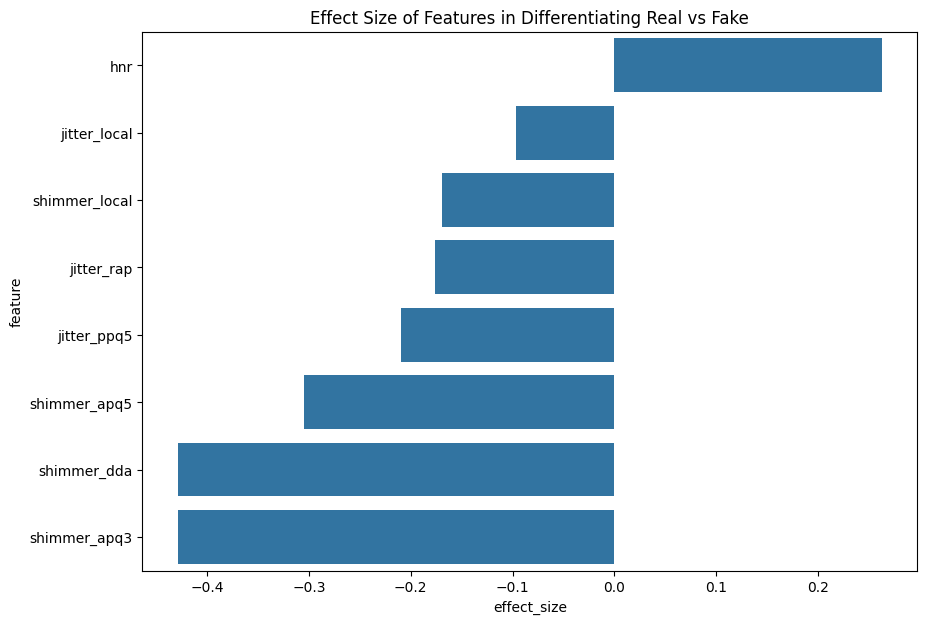

In [18]:
# Visualize the results
plt.figure(figsize=(10, 7))
sns.barplot(x='effect_size', y='feature', data=stats_df.sort_values(by='effect_size', ascending=False))
plt.title('Effect Size of Features in Differentiating Real vs Fake')
plt.show()

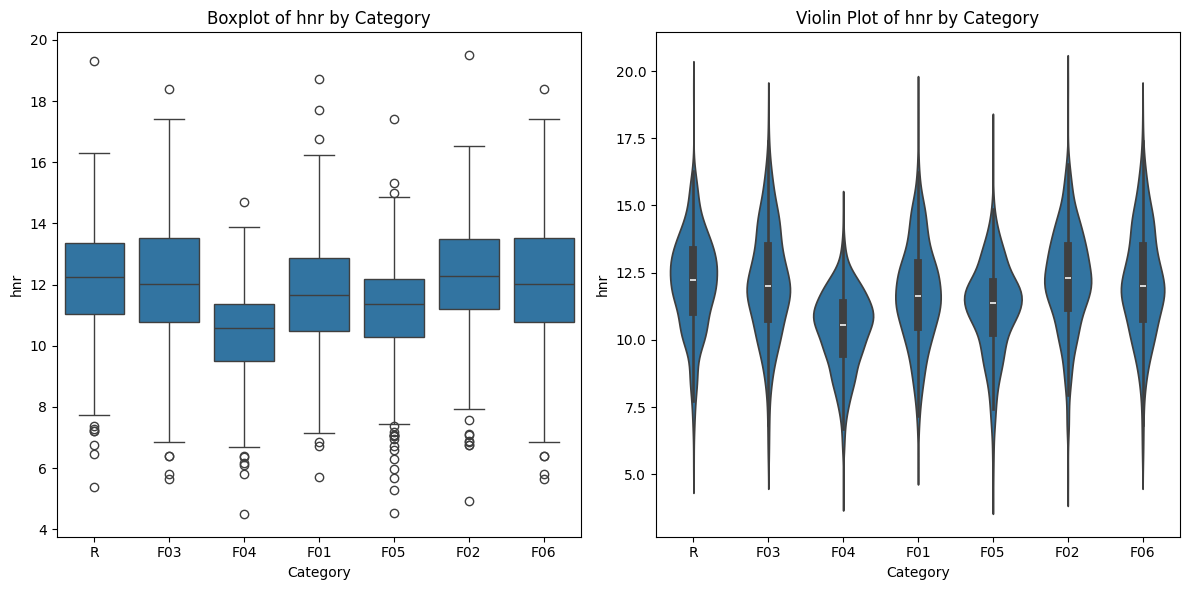

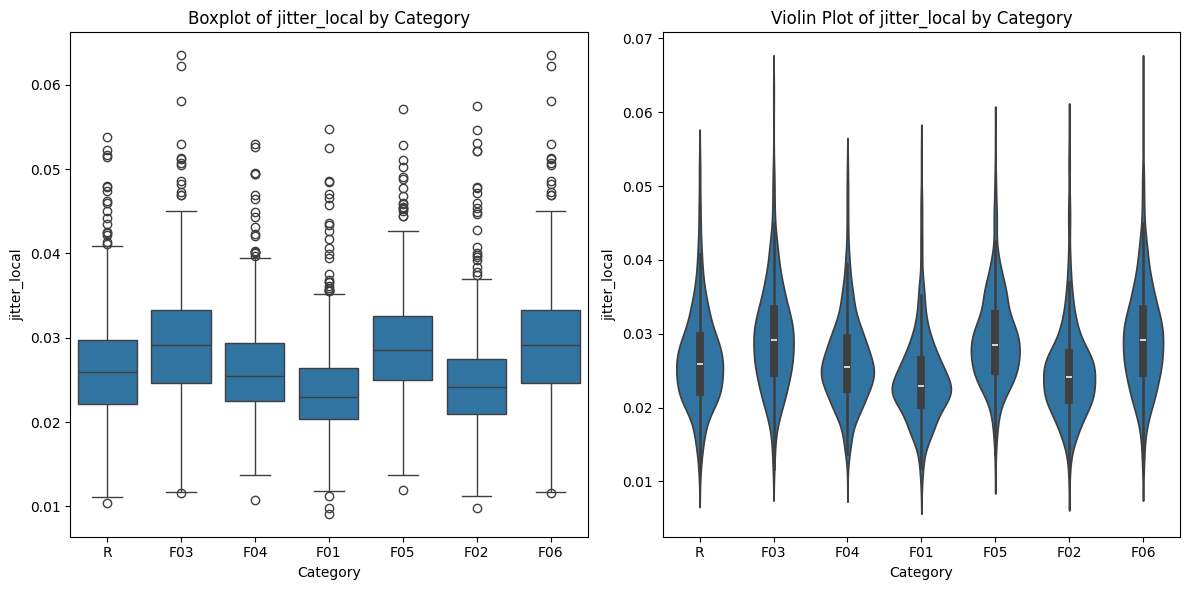

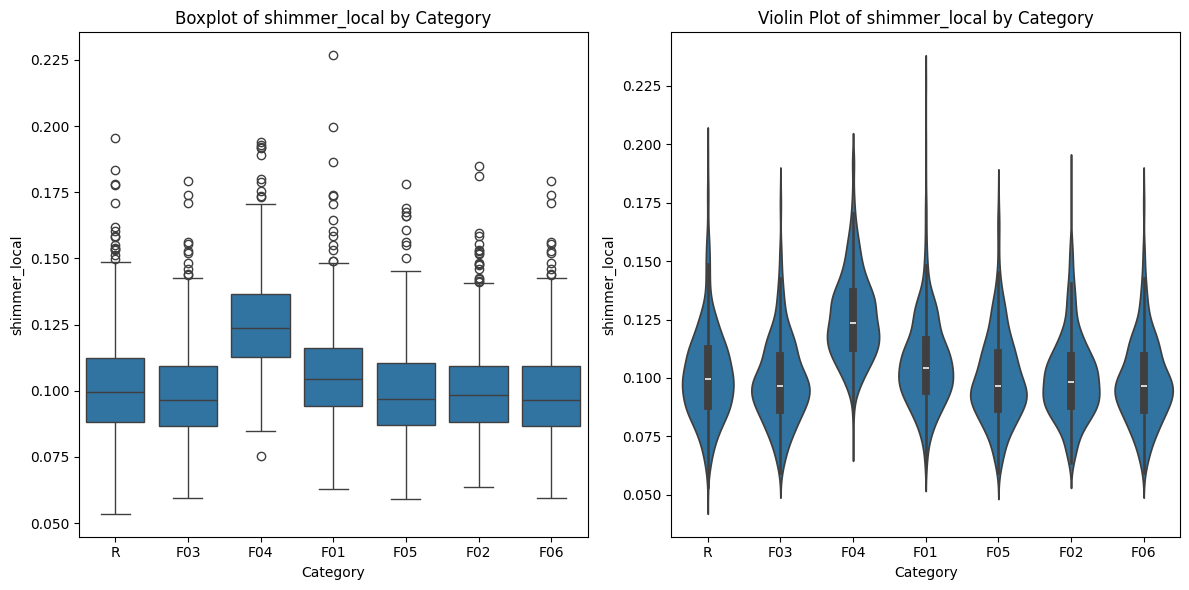

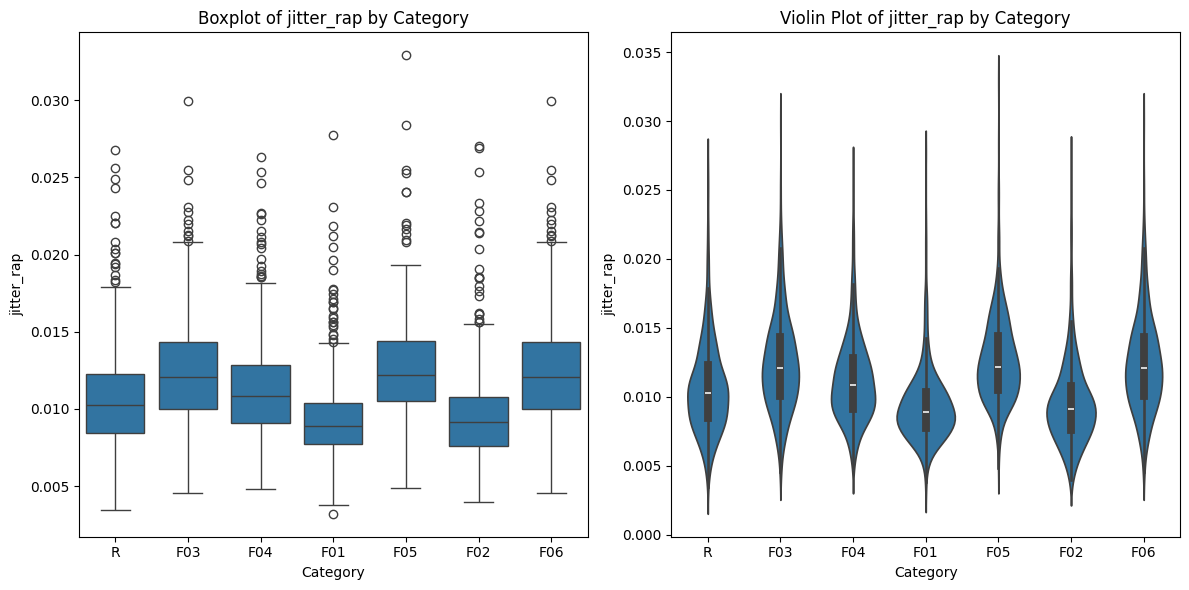

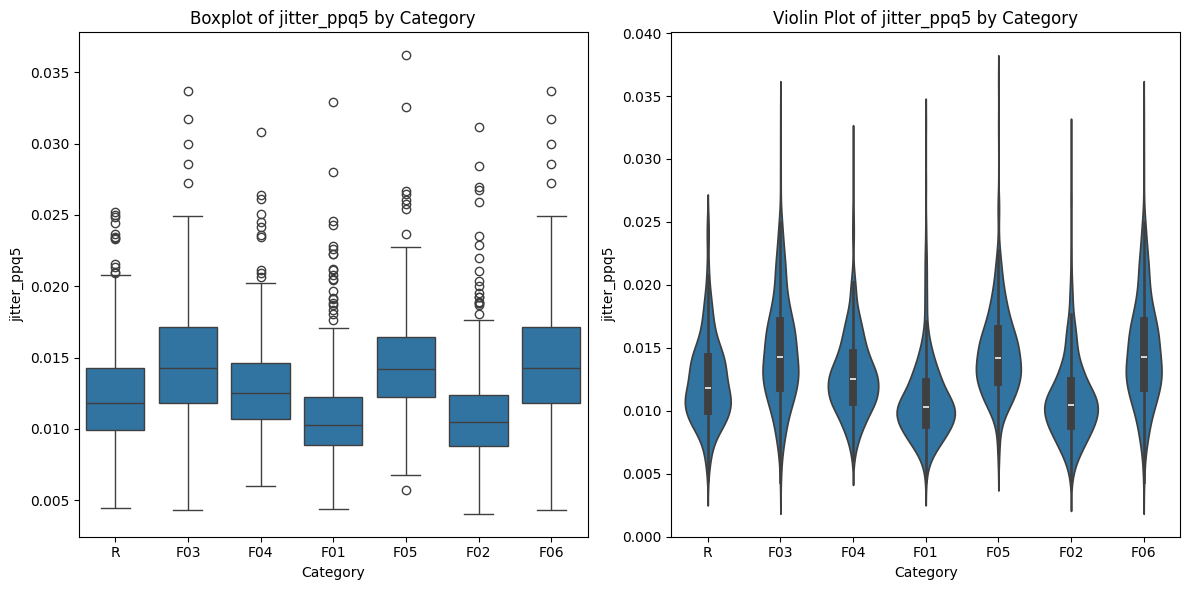

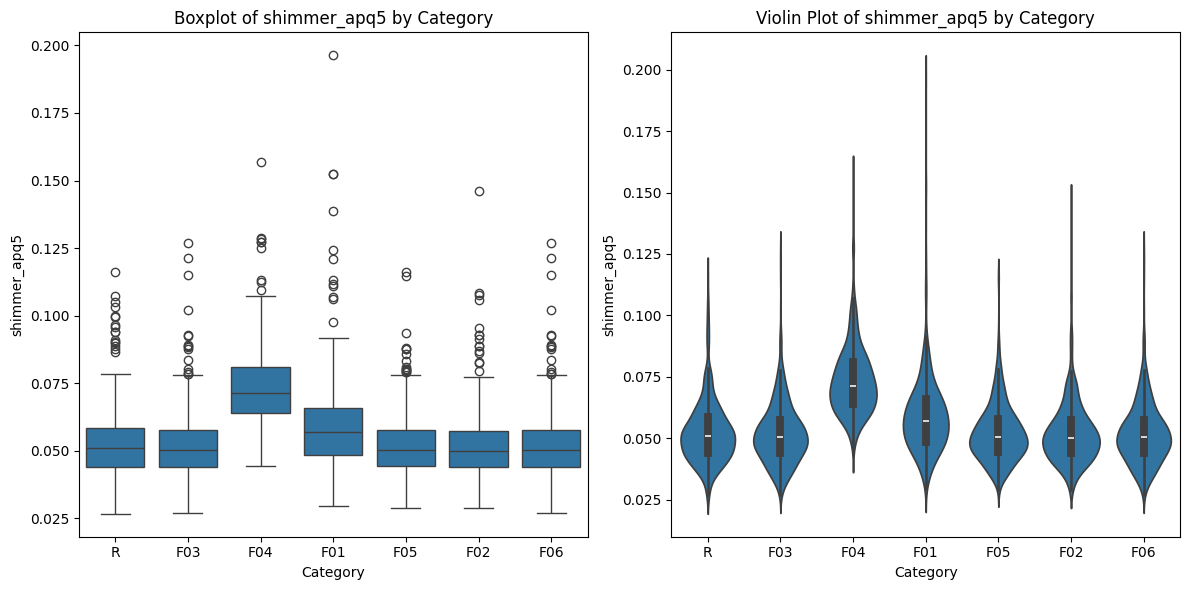

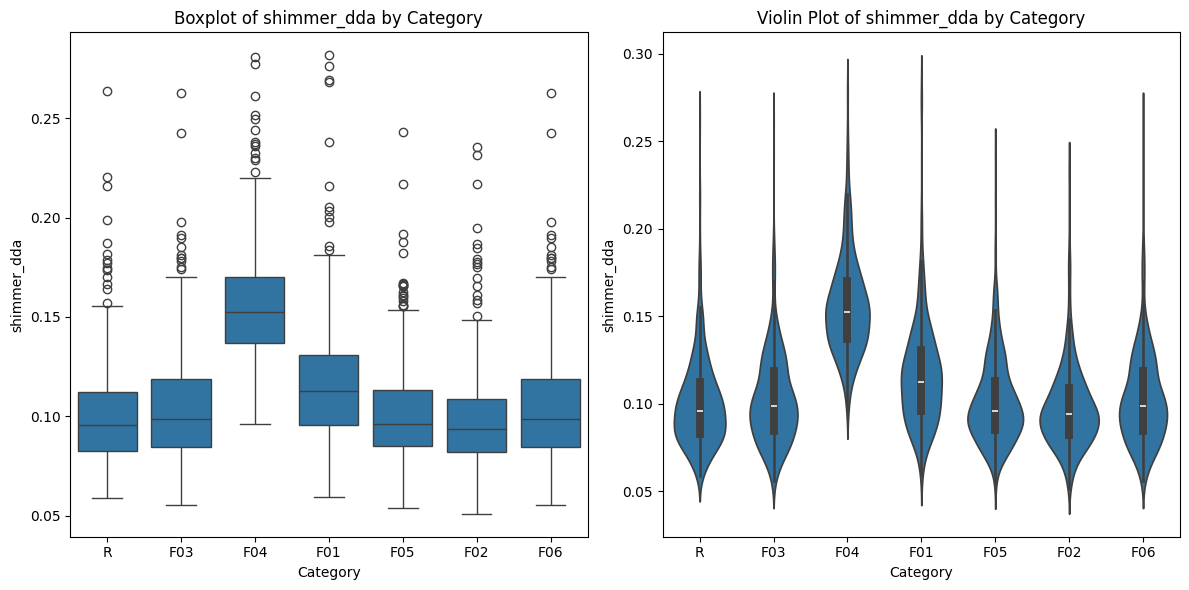

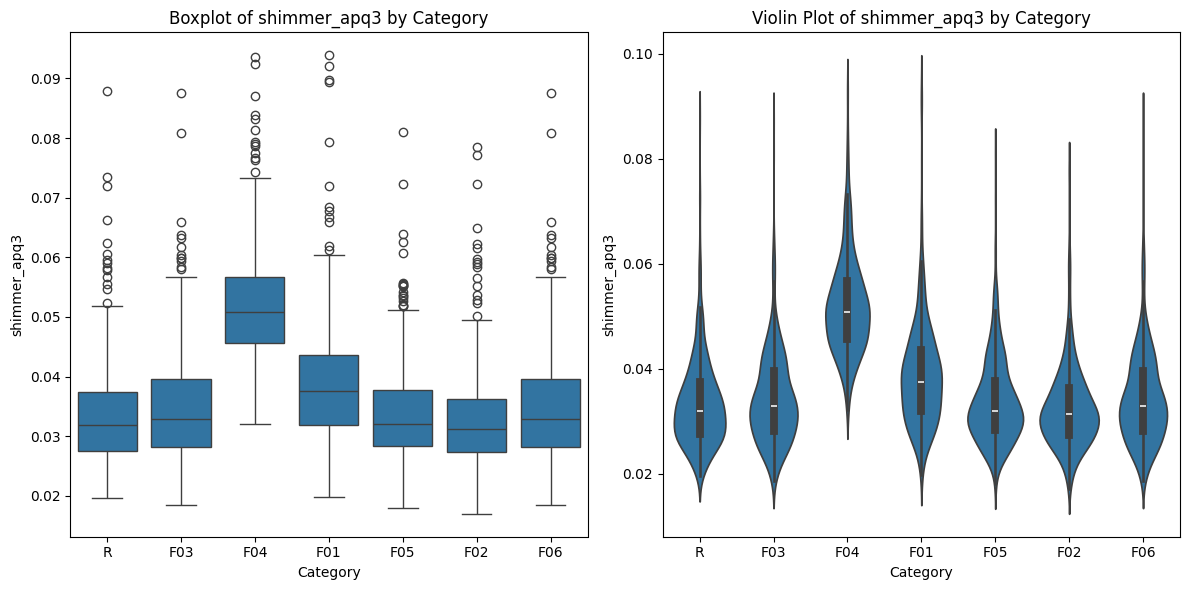

In [19]:
all_features = stats_df.sort_values(by=['effect_size'], ascending=False).feature.tolist()
plot_high_level_feature_dist(high_level_feature_df, all_features[:10])

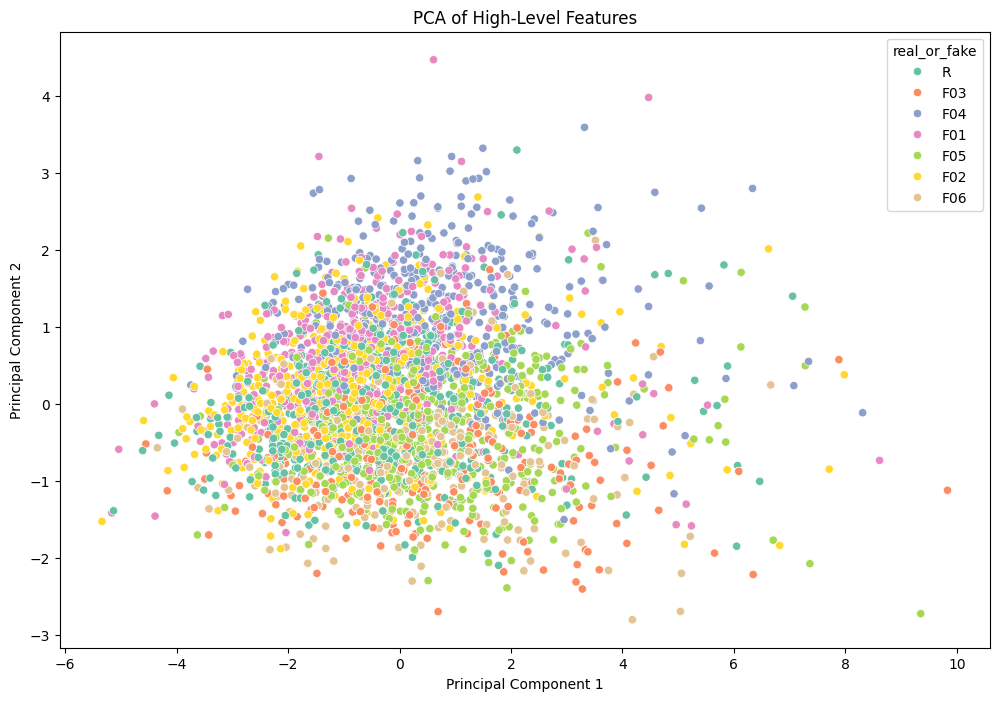

In [20]:
perform_pca_and_plot(high_level_feature_df, all_features[:5])

In [21]:
def logistic_regression_feature_importance(df, selected_features, target_column='real_or_fake'):
    # Drop columns with NaN values
    df_clean = df.dropna(axis=1)
    
    # Ensure selected features are in the cleaned DataFrame
    selected_features = [feature for feature in selected_features if feature in df_clean.columns]

    X = df_clean[selected_features]
    y = df_clean[target_column].apply(lambda x: 1 if x == 'R' else 0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LogisticRegression()
    model.fit(X_scaled, y)
    
    feature_importances = model.coef_[0]
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)

    return importance_df

importance_df = logistic_regression_feature_importance(high_level_feature_df, all_features)
importance_df

,feature,importance
2,shimmer_local,0.764363
1,jitter_local,0.498495
0,hnr,0.202926
5,shimmer_apq5,-0.123632
3,jitter_rap,-0.170283
4,jitter_ppq5,-0.347373
7,shimmer_apq3,-0.462491
6,shimmer_dda,-0.462491


### Redundant Features

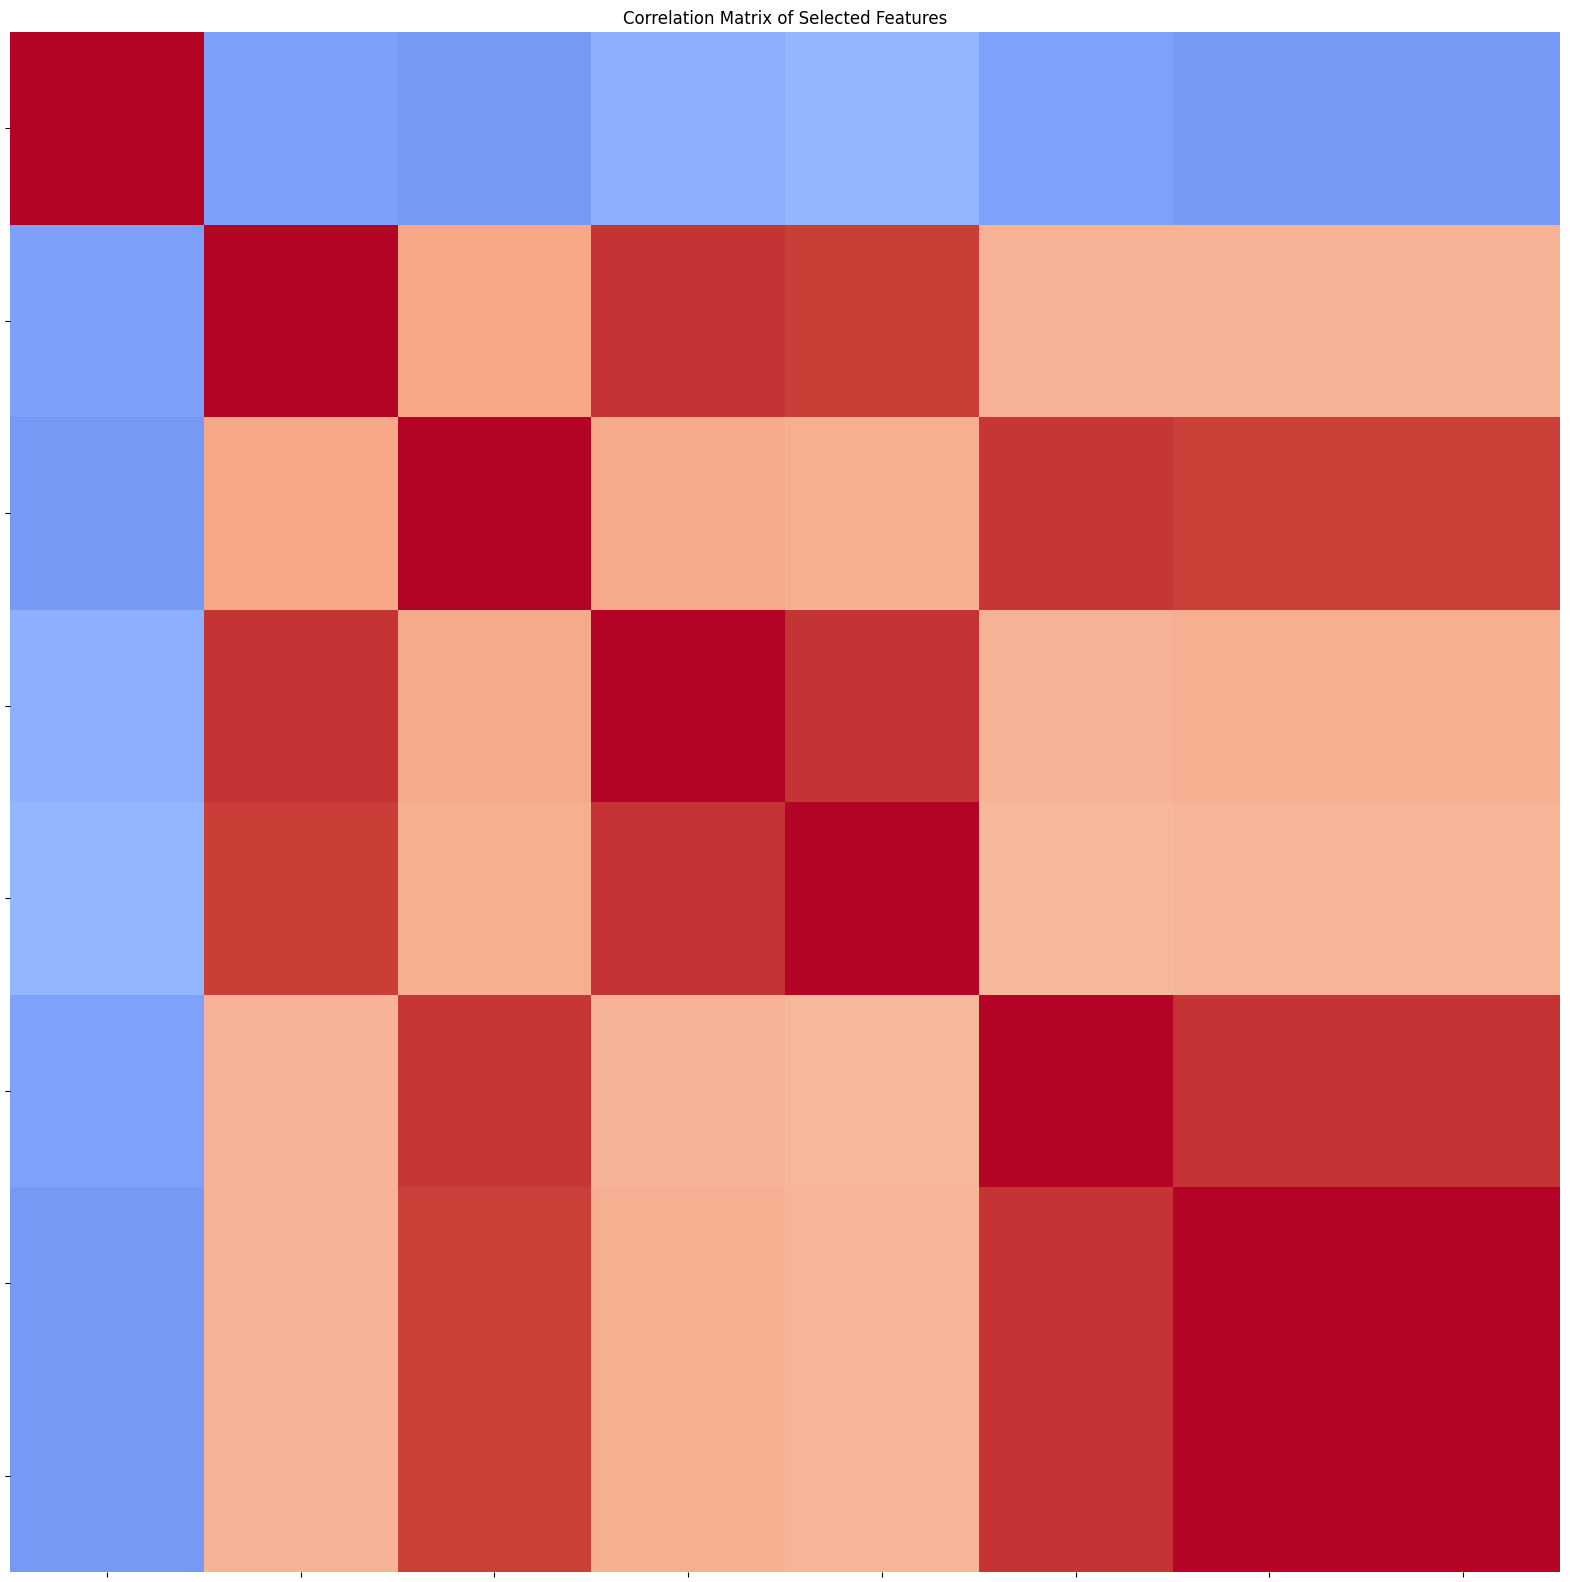

In [22]:
def compute_correlation_matrix(df, selected_features):
    return df[selected_features].corr()

correlation_matrix = compute_correlation_matrix(high_level_feature_df, all_features)

plt.figure(figsize=(20, 20))
ax = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [23]:
def remove_highly_correlated_features(df, selected_features, threshold=0.6):
    correlation_matrix = df[selected_features].corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    # Remove redundant features
    reduced_features = [feature for feature in selected_features if feature not in to_drop]

    return reduced_features


reduced_features = remove_highly_correlated_features(high_level_feature_df, all_features)
print(f"Reduced Features: {reduced_features}")


Reduced Features: ['hnr', 'jitter_local']


In [24]:
high_level_feature_df[reduced_features].dropna().isna().sum()

hnr             0
jitter_local    0
dtype: int64

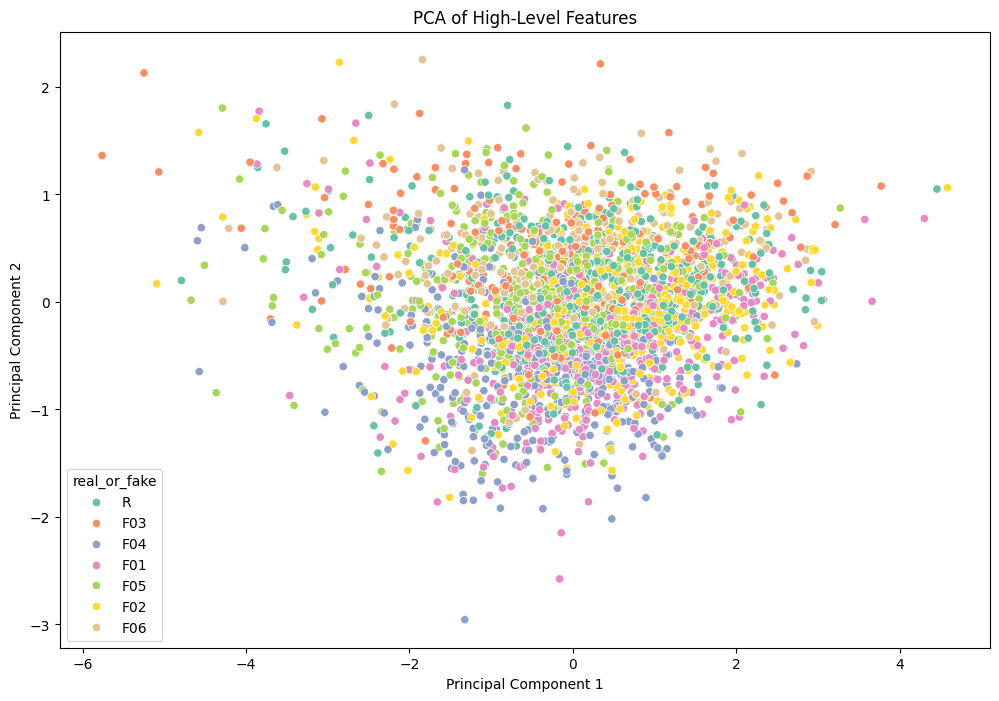

In [25]:
perform_pca_and_plot(high_level_feature_df, reduced_features[:2])

In [26]:
importance_df = logistic_regression_feature_importance(high_level_feature_df, reduced_features)
importance_df

,feature,importance
0,hnr,0.310208
1,jitter_local,0.089189


### Baseline Model

In [27]:
good_features = reduced_features
imputer = SimpleImputer(strategy='mean')

In [28]:
X = high_level_feature_df[good_features]
X = imputer.fit_transform(X)
y = high_level_feature_df['real_or_fake'].apply(lambda x: 1 if x == 'R' else 0)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

model_performance = {}

for model_name, model in models.items():

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Fake', 'Real'])
    
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Classification Report': report
    }


for model_name, metrics in model_performance.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print("Classification Report:\n", metrics['Classification Report'])
    print("-" * 60)


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_clas

Model: Logistic Regression
Accuracy: 0.8429
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Classification Report:
               precision    recall  f1-score   support

        Fake       0.84      1.00      0.91       590
        Real       0.00      0.00      0.00       110

    accuracy                           0.84       700
   macro avg       0.42      0.50      0.46       700
weighted avg       0.71      0.84      0.77       700

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8286
Precision: 0.2917
Recall: 0.0636
F1 Score: 0.1045
Classification Report:
               precision    recall  f1-score   support

        Fake       0.85      0.97      0.91       590
        Real       0.29      0.06      0.10       110

    accuracy                           0.83       700
   macro avg       0.57      0.52      0.50       700
weighted avg       0.76      0.83      0.78       700

-------------------------------------------------------

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_clas